In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) y
Token is valid (permission: fineGrained).
The token `Google Colab 1` has been saved to /root/.cache/huggingface/stored_tokens
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authen

In [ ]:
!pip install -q transformers datasets librosa

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
from transformers import AutoModel, AutoTokenizer
from datasets import load_dataset

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import os
import re
import random
import itertools
from collections import defaultdict
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt

In [ ]:
def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42)

#### 🌀 Загружаем данные (предварительно загрузите их с диска в Google Colab)

[Ссылка на данные](https://disk.yandex.ru/d/awG8jCY01BGcAQ)

In [ ]:
labels = ["anger", "disgust", "fear", "joy", "sadness", "surprise", "neutral"]

In [ ]:
# labels = ["anger", "disgust", "fear", "joy", "sadness", "surprise", "neutral"]

data = load_dataset("csv", data_files={"train": "/content/train.csv", "validation": "/content/valid.csv"})
data

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral'],
        num_rows: 69973
    })
    validation: Dataset({
        features: ['text', 'anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral'],
        num_rows: 5426
    })
})

In [ ]:
from datasets import concatenate_datasets


# Загрузка основных файлов и дополнительных данных
labels = ["anger", "disgust", "fear", "joy", "sadness", "surprise", "neutral"]

data = load_dataset("csv", data_files={
    "train": "/content/train.csv",
    "validation": "/content/valid.csv"
})

# Загрузка дополнительных файлов
fear_additional = load_dataset("csv", data_files="/content/fear_additional.csv")["train"]
disgust_additional = load_dataset("csv", data_files="/content/disgust_additional.csv")["train"]

# Объединение дополнительных файлов с основным train
data["train"] = concatenate_datasets([data["train"], fear_additional, disgust_additional])

# Проверка
print(f"Train dataset size after concatenation: {len(data['train'])}")


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Train dataset size after concatenation: 45082


#### 🔎 Выведем уникальные символы в сплитах

In [ ]:
def get_alphabet(data_split):
    alphabet = set()
    for sample in data_split:
        uniq_chars = set(sample["text"])
        alphabet.update(uniq_chars)
    return alphabet

print("Train unique symbols: ", get_alphabet(data["train"]))
print("Valid unique symbols: ", get_alphabet(data["validation"]))

Train unique symbols:  {'⠴', '做', ';', '👶', '查', 'Ъ', 'ɴ', '💚', '😦', '🇲', '💃', '🧡', '😛', '🇸', 'б', 'у', '⠻', '͍', '🇹', 'Ч', '♂', '你', 'э', '🚀', '❤', 'Ò', '😏', '🏾', '3', 'O', '🤲', '>', 'Z', '͈', '😂', '🙄', 'Х', '⡄', 'Ф', '清', '⠉', "'", 'l', '?', '⢸', 'R', '⣘', '⡇', '⡷', 'i', '😤', '人', '™', '🎣', '💁', '😶', 'О', '😄', '❣', '͝', '카', '̪', '😾', '😇', '"', '🏊', '油', 'w', 'W', '👓', '☆', '🕺', '|', '•', '🏈', '🍰', '😣', '⣷', '😜', '⣹', 'r', 'ī', '️', '_', 's', ':', '💔', '⠃', '“', '👑', '⚡', '̣', '🦵', 'ᴅ', '加', '😎', '발', '청', '🌊', 'M', 'г', '⣆', '🤰', '💥', '💄', 'Ш', '🗑', 'М', '`', '<', '💯', '😫', '➡', 'ᴏ', '🧀', 'ɢ', 'G', 'h', '⣤', '💕', '⣿', '̳', '#', '̼', '情', '̲', 'н', '2', '͚', '🇺', 'Р', '😟', 'L', 'ɡ', '☕', 'А', '👅', 'ᴛ', '̫', 'ñ', '･', '·', '😘', '😉', '%', '̕', '͏', 'X', '⠸', 'щ', 'K', '͢', '🙃', 'é', '😥', '🇵', '🎖', 'U', '😅', '🤜', '니', 'Я', '🤯', '😍', ',', 'B', 'е', 'ᴀ', '̺', '👁', '🥘', '⠹', 'И', '⠏', '🍿', '̬', '̙', 'Y', '😵', '⣠', '♥', '\u200b', '🎶', '🚫', '~', '⢠', '👌', '😰', '🧛', 'В', '🍕', '(', '💜', 'З', '

#### 📊 Построим гистограммы распределения

In [ ]:
def plot_histogram(data_split):
    class_counts = {
        'anger': 0,
        'disgust': 0,
        'fear': 0,
        'joy': 0,
        'sadness': 0,
        'surprise': 0,
        'neutral': 0
    }

    for sample in data_split:
        for emotion in labels:
            class_counts[emotion] += sample[emotion]

    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts)
    plt.xlabel('Классы эмоций')
    plt.ylabel('Количество')
    plt.title('Распределение по классам эмоций')
    plt.xticks(rotation=45)

    plt.show()

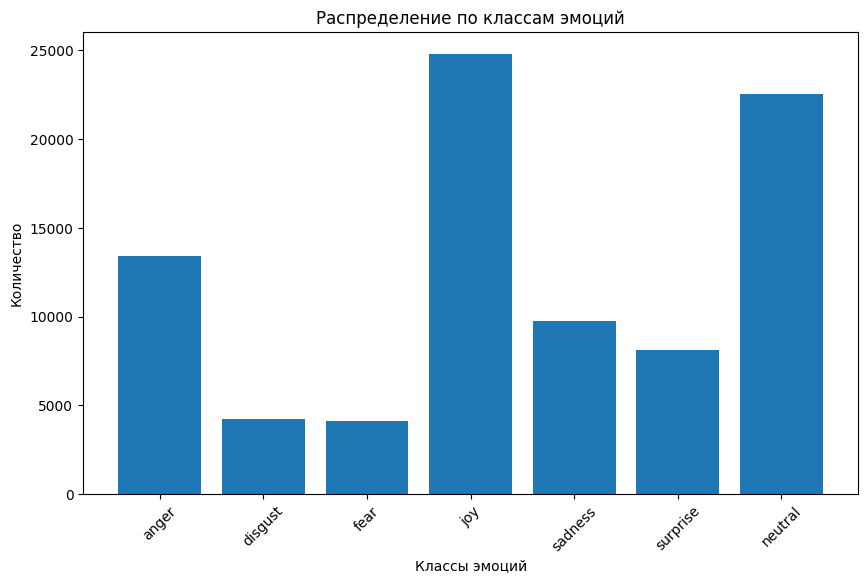

In [ ]:
plot_histogram(data["train"])

In [ ]:
def plot_combined_emotions(data_split):
    emotion_pairs = defaultdict(int)

    for entry in data_split:
        emotions = {key: value for key, value in entry.items() if key in labels}
        active_emotions = [emotion for emotion, value in emotions.items() if value > 0]

        for pair in itertools.combinations(sorted(active_emotions), 2):
            emotion_pairs[pair] += 1

    sorted_pairs = sorted(emotion_pairs.items(), key=lambda x: x[1], reverse=True)
    pairs = [f"{pair[0]} & {pair[1]}" for pair, _ in sorted_pairs]
    counts = [count for _, count in sorted_pairs]

    plt.figure(figsize=(12, 6))
    plt.bar(pairs, counts)
    plt.xlabel('Пары эмоций')
    plt.ylabel('Количество')
    plt.title('Совместное появление эмоций')
    plt.xticks(rotation=45)

    plt.show()

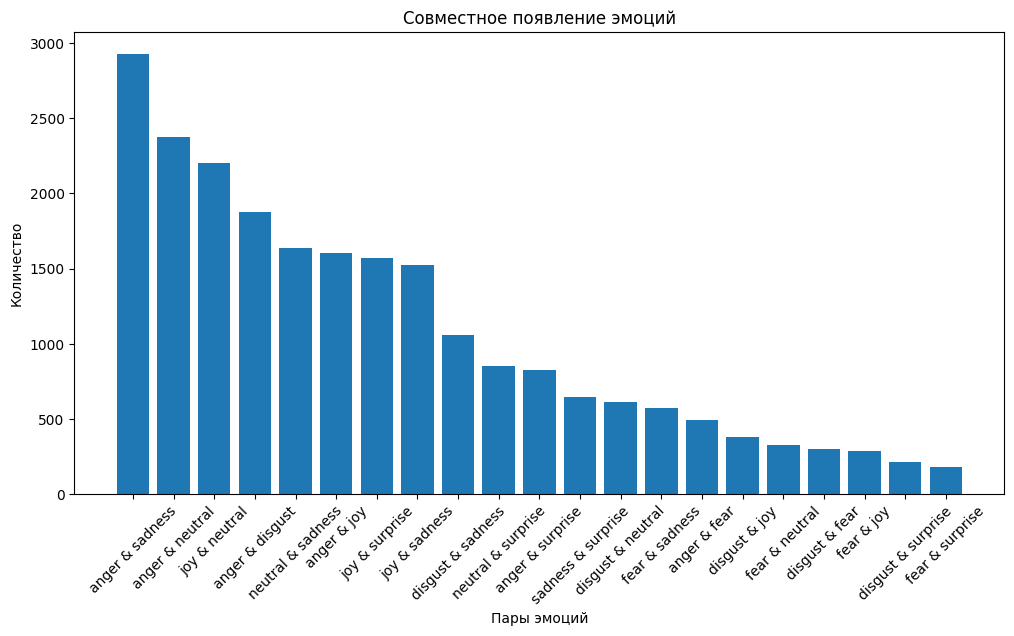

In [ ]:
plot_combined_emotions(data["train"])

#### 🧹 Приведем тексты к нижнему регистру и удалим лишние знаки

In [ ]:
data

DatasetDict({
    train: Dataset({
        features: ['text', 'anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral'],
        num_rows: 69973
    })
    validation: Dataset({
        features: ['text', 'anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral'],
        num_rows: 5426
    })
})

In [ ]:
def cleaner(example):
    example["text"] = example["text"].lower()
    example["text"] = re.sub(r"[^a-zа-я\d]", " ", example["text"])
    example["text"] = re.sub(r"\s+", " ", example["text"])
    example["text"] = example["text"].strip()
    return example

In [ ]:
data = data.map(cleaner)

Map:   0%|          | 0/69973 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

In [ ]:
# Обработка эмодзи
!pip install emoji
import emoji

def process_emojis(example):
    example["text"] = emoji.demojize(example["text"], delimiters=("", ""))
    return example

data = data.map(process_emojis)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 8.9 MB/s eta 0:00:00


Map:   0%|          | 0/69973 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

In [ ]:
# Обработка ошибок ASR
def process_asr_errors(example):
    asr_error_map = {
        "што": "что",
        "карова": "корова",
        "сечас": "сейчас",
        "патом": "потом",
        "другова": "другого",
        "ебу": "я буду",
        # Расширяем словарь
        "вроде бы": "вроде бы",
        "шя": "сейчас",
        "ыетс": "это",
        "ана": "она",
        "ужеж": "уже",
    }
    for error, correct in asr_error_map.items():
        example["text"] = example["text"].replace(error, correct)
    return example

data = data.map(process_asr_errors)

Map:   0%|          | 0/69973 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

In [ ]:
data["train"][3]

{'text': 'чтобы она почувствовала угрозу',
 'anger': 0,
 'disgust': 0,
 'fear': 1,
 'joy': 0,
 'sadness': 0,
 'surprise': 0,
 'neutral': 0}

In [ ]:
# import random
# from datasets import concatenate_datasets, DatasetDict

# def augment_text(example):
#     words = example["text"].split()
#     if len(words) > 1:
#         random.shuffle(words)  # Перестановка слов
#     example["text"] = " ".join(words)
#     return example

# augmentation_classes = ["disgust", "fear"]
# augmented_data = []

# # Аугментация данных
# for cls in augmentation_classes:
#     class_data = data["train"].filter(lambda x: x[cls] == 1)
#     augmented_class_data = class_data.map(augment_text)
#     augmented_data.append(augmented_class_data)

# # Объединяем оригинальные и аугментированные данные
# augmented_dataset = concatenate_datasets([data["train"], *augmented_data])

# # Обновляем DatasetDict
# data = DatasetDict({
#     "train": augmented_dataset,
#     "validation": data["validation"]
# })

# # Проверка
# print(data["train"][:5])  # Пример первых строк
# print(f"Train dataset size: {len(data['train'])}")


In [ ]:
from transformers import MarianMTModel, MarianTokenizer

# Инициализация модели для перевода
def initialize_translation_model():
    src_lang = "ru"  # Исходный язык
    tgt_lang = "en"  # Язык перевода
    model_name = f"Helsinki-NLP/opus-mt-{src_lang}-{tgt_lang}"
    reverse_model_name = f"Helsinki-NLP/opus-mt-{tgt_lang}-{src_lang}"

    forward_model = MarianMTModel.from_pretrained(model_name)
    forward_tokenizer = MarianTokenizer.from_pretrained(model_name)

    reverse_model = MarianMTModel.from_pretrained(reverse_model_name)
    reverse_tokenizer = MarianTokenizer.from_pretrained(reverse_model_name)

    return forward_model, forward_tokenizer, reverse_model, reverse_tokenizer

forward_model, forward_tokenizer, reverse_model, reverse_tokenizer = initialize_translation_model()

# Аугментация: перевод на английский и обратно
def back_translation(example):
    text = example["text"]
    # Перевод на английский
    inputs = forward_tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    translated = forward_model.generate(**inputs)
    translated_text = forward_tokenizer.batch_decode(translated, skip_special_tokens=True)[0]

    # Перевод обратно на русский
    inputs = reverse_tokenizer(translated_text, return_tensors="pt", padding=True, truncation=True)
    retranslated = reverse_model.generate(**inputs)
    retranslated_text = reverse_tokenizer.batch_decode(retranslated, skip_special_tokens=True)[0]

    example["text"] = retranslated_text
    return example

# Аугментация: замена синонимами
import nltk
from nltk.corpus import wordnet

nltk.download("wordnet")

def synonym_replacement(example):
    words = example["text"].split()
    new_words = []

    for word in words:
        synonyms = wordnet.synsets(word)
        if synonyms:
            # Замена слова случайным синонимом
            synonym = synonyms[0].lemmas()[0].name()
            new_words.append(synonym)
        else:
            new_words.append(word)

    example["text"] = " ".join(new_words)
    return example

# Аугментация данных для эмоций
augmentation_classes = ["disgust", "fear"]
augmented_data = []

for cls in augmentation_classes:
    class_data = data["train"].filter(lambda x: x[cls] == 1)
    # Применяем два типа аугментации
    augmented_back_translation = class_data.map(back_translation)
    augmented_synonym_replacement = class_data.map(synonym_replacement)
    augmented_data.extend([augmented_back_translation, augmented_synonym_replacement])

# Объединяем все данные
augmented_dataset = concatenate_datasets([data["train"], *augmented_data])

# Обновляем train в DatasetDict
data["train"] = augmented_dataset

# Проверка
print(f"Train dataset size after augmentation: {len(data['train'])}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/307M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/803k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.60M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/307M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/803k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.60M [00:00<?, ?B/s]

[nltk_data] Downloading package wordnet to /root/nltk_data...


Filter:   0%|          | 0/45082 [00:00<?, ? examples/s]

Map:   0%|          | 0/1528 [00:00<?, ? examples/s]

Parameter 'function'=<function synonym_replacement at 0x7bb1380edea0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/1528 [00:00<?, ? examples/s]

Filter:   0%|          | 0/45082 [00:00<?, ? examples/s]

Map:   0%|          | 0/1663 [00:00<?, ? examples/s]

Map:   0%|          | 0/1663 [00:00<?, ? examples/s]

Train dataset size after augmentation: 51464


In [ ]:
# Преобразование train в Pandas DataFrame
train_df = data["train"].to_pandas()

# Сохранение в CSV
train_df.to_csv("/content/train_aug.csv", index=False)

print("Файл успешно сохранён как train_aug.csv")


Файл успешно сохранён как train_aug.csv


In [ ]:
from google.colab import files
files.download("/content/train_aug.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print(f"Размер нового train: {len(data['train'])}")

Размер нового train: 51464


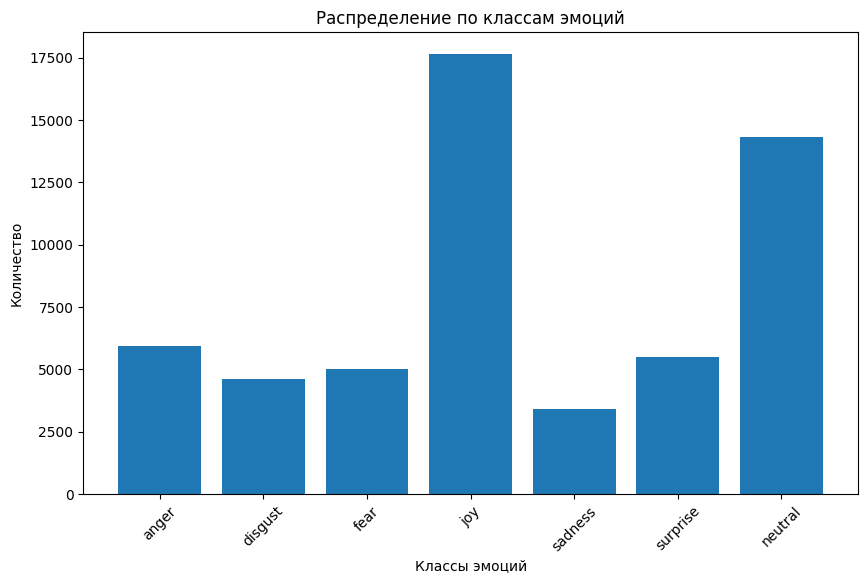

In [ ]:
plot_histogram(data["train"])

In [ ]:
data["train"][3]

{'text': 'чтобы она почувствовала угрозу',
 'anger': 0,
 'disgust': 0,
 'fear': 1,
 'joy': 0,
 'sadness': 0,
 'surprise': 0,
 'neutral': 0}

In [ ]:
for i in range(5):
    print(data["train"][i]["text"])


моя любимая еда это все что мне не приходилось готовить самому
теперь если он покончит с собой все будут думать что он смеется трахая людей а не на самом деле мертв
какого нахрона бэйлесская изоинция
чтобы она почувствовала угрозу
грязные южные дрочники


In [ ]:
from datasets import DatasetDict, concatenate_datasets

# Подсчитываем количество примеров в каждом классе
class_distribution = {
    cls: sum(data["train"][cls]) for cls in labels
}
print(f"Class distribution before balancing: {class_distribution}")

# Пример undersampling
balanced_datasets = []
min_count = min(class_distribution.values())
for cls in labels:
    class_samples = data["train"].filter(lambda x: x[cls] == 1)
    balanced_datasets.append(class_samples.shuffle(seed=42).select(range(min_count)))

# Объединяем сбалансированные данные
balanced_train = concatenate_datasets(balanced_datasets)

# Обновляем DatasetDict
data = DatasetDict({
    "train": balanced_train,
    "validation": data["validation"]
})

# Проверка
print(f"Class distribution after balancing: {min_count} samples per class")
print(f"New train dataset size: {len(data['train'])}")


Class distribution before balancing: {'anger': 5937, 'disgust': 4608, 'fear': 5013, 'joy': 17640, 'sadness': 3425, 'surprise': 5495, 'neutral': 14331}


Filter:   0%|          | 0/51464 [00:00<?, ? examples/s]

Filter:   0%|          | 0/51464 [00:00<?, ? examples/s]

Filter:   0%|          | 0/51464 [00:00<?, ? examples/s]

Filter:   0%|          | 0/51464 [00:00<?, ? examples/s]

Filter:   0%|          | 0/51464 [00:00<?, ? examples/s]

Filter:   0%|          | 0/51464 [00:00<?, ? examples/s]

Filter:   0%|          | 0/51464 [00:00<?, ? examples/s]

Class distribution after balancing: 3425 samples per class
New train dataset size: 23975


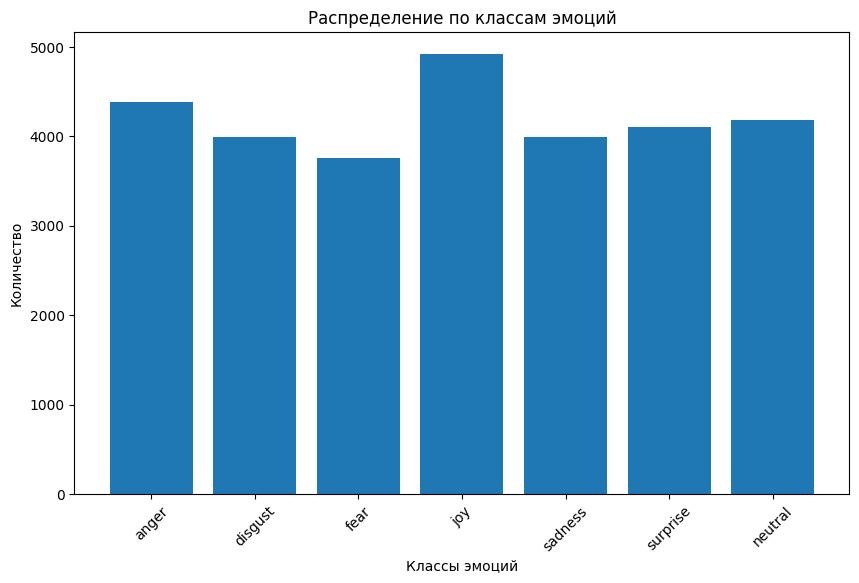

In [ ]:
plot_histogram(data["train"])

In [ ]:
# Преобразование train в Pandas DataFrame
balanced_train = data["train"].to_pandas()

# Сохранение в CSV
train_df.to_csv("/content/balanced_train.csv", index=False)

print("Файл успешно сохранён как balanced_train.csv")

from google.colab import files
files.download("/content/balanced_train.csv")

Файл успешно сохранён как balanced_train.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
balanced_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23975 entries, 0 to 23974
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      23975 non-null  object
 1   anger     23975 non-null  int64 
 2   disgust   23975 non-null  int64 
 3   fear      23975 non-null  int64 
 4   joy       23975 non-null  int64 
 5   sadness   23975 non-null  int64 
 6   surprise  23975 non-null  int64 
 7   neutral   23975 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 1.5+ MB


#### 🏋️ Подготовим модель

In [ ]:
import torch.nn as nn

class Model(nn.Module):
    def __init__(self, pretrained_model, hidden_dim, num_classes):
        super().__init__()
        self.bert = AutoModel.from_pretrained(pretrained_model)
        self.dropout = nn.Dropout(p=0.3)  # Dropout с вероятностью 30%
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, ids, mask, token_type_ids):
        _, features = self.bert(ids, attention_mask=mask, token_type_ids=token_type_ids, return_dict=False)
        features = self.dropout(features)  # Применение Dropout
        output = self.fc(features)
        return output

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model(pretrained_model="ai-forever/ruBert-base", hidden_dim=768, num_classes=len(labels))
model = model.to(device)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/590 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/716M [00:00<?, ?B/s]

#### 📒 Подготовим данные для обучения

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("ai-forever/ruBert-base")
max_len = 64

data = data.map(lambda examples: tokenizer(examples["text"],
                                           truncation=True,
                                           add_special_tokens=True,
                                           max_length=max_len,
                                           padding="max_length"), batched=True)

vocab.txt:   0%|          | 0.00/1.78M [00:00<?, ?B/s]

Map:   0%|          | 0/69973 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

In [ ]:
def one_hot_to_list(example):
    emotions = []
    for emotion in labels:
        emotions.append(example[emotion])
    example["one_hot_labels"] = emotions

    return example

data = data.map(one_hot_to_list)
data["train"][9]["one_hot_labels"]

Map:   0%|          | 0/69973 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

[0, 0, 0, 0, 0, 0, 1]

#### 🔗 Dataset & DataLoader

In [ ]:
class EmotionDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        return {
            'input_ids': torch.tensor(self.dataset[index]["input_ids"], dtype=torch.long),
            'attention_mask': torch.tensor(self.dataset[index]["attention_mask"], dtype=torch.long),
            'token_type_ids': torch.tensor(self.dataset[index]["token_type_ids"], dtype=torch.long),
            'labels': torch.tensor(self.dataset[index]["one_hot_labels"], dtype=torch.float)
        }

In [ ]:
train_dataset = EmotionDataset(data["train"])
valid_dataset = EmotionDataset(data["validation"])

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

#### 🚀 Инициализируем функцию ошибки и оптимизатор

In [ ]:
criterion = torch.nn.BCEWithLogitsLoss()
# optimizer = torch.optim.Adam(params=model.parameters(), lr=0.00001, weight_decay=0.)
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-5, weight_decay=1e-5)

#### 🥷 Код для обучения и валидации

In [ ]:
def train(model, criterion, optimizer, dataloader):
    train_loss = 0.0
    model.train()
    for idx, data in enumerate(dataloader):
        ids = data["input_ids"].to(device, dtype=torch.long)
        mask = data["attention_mask"].to(device, dtype=torch.long)
        token_type_ids = data["token_type_ids"].to(device, dtype=torch.long)
        labels = data["labels"].to(device, dtype=torch.float)

        outputs = model(ids, mask, token_type_ids)
        loss = criterion(outputs, labels)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    print(f'Train loss: {train_loss / len(dataloader)}')

    return model

In [ ]:
def validation(model, criterion, dataloader):
    val_loss = 0.0
    model.eval()
    val_targets, val_outputs = [], []
    with torch.no_grad():
        for idx, data in enumerate(dataloader):
            ids = data["input_ids"].to(device, dtype=torch.long)
            mask = data["attention_mask"].to(device, dtype=torch.long)
            token_type_ids = data["token_type_ids"].to(device, dtype=torch.long)
            labels = data["labels"].to(device, dtype=torch.float)

            outputs = model(ids, mask, token_type_ids)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            val_targets.extend(labels.cpu().detach().numpy().tolist())
            val_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

    print(f'Valid loss: {val_loss / len(dataloader)}')

    return val_outputs, val_targets

#### 🏃‍♂️‍➡️ Запускаем обучение

In [ ]:
epochs = 3

for epoch in range(epochs):
    print(f"Epoch: {epoch}")
    model = train(model, criterion, optimizer, train_dataloader)
    val_outputs, val_targets = validation(model, criterion, valid_dataloader)


Epoch: 0
Train loss: 0.34217225181337246
Valid loss: 0.24656211979248943
Epoch: 1
Train loss: 0.28841163693387506
Valid loss: 0.2361913007848403
Epoch: 2
Train loss: 0.26639832375091
Valid loss: 0.2460691329310922


In [ ]:
outputs, targets = validation(model, criterion, valid_dataloader)
outputs = np.array(outputs) >= 0.5
print(metrics.classification_report(targets, outputs, target_names=labels))

Valid loss: 0.2460691329310922
              precision    recall  f1-score   support

       anger       0.48      0.59      0.53       717
     disgust       0.36      0.56      0.44        97
        fear       0.46      0.61      0.52       105
         joy       0.83      0.79      0.81      2219
     sadness       0.52      0.64      0.57       390
    surprise       0.62      0.28      0.39       624
     neutral       0.69      0.57      0.63      1766

   micro avg       0.68      0.63      0.65      5918
   macro avg       0.57      0.58      0.56      5918
weighted avg       0.69      0.63      0.65      5918
 samples avg       0.65      0.65      0.64      5918



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.metrics import accuracy_score, f1_score

# Бинаризация предсказаний (порог 0.5)
val_outputs_binary = (np.array(val_outputs) >= 0.5).astype(int)

# Повторный расчет метрик
accuracy = accuracy_score(np.array(val_targets), val_outputs_binary)
print(f"Accuracy: {accuracy:.4f}")

weighted_f1 = f1_score(np.array(val_targets), val_outputs_binary, average='weighted', zero_division=0)
print(f"Weighted Average F1-score: {weighted_f1:.4f}")


Accuracy: 0.5621
Weighted Average F1-score: 0.6500


#### ✏️ Получаем результаты на тесте

In [ ]:
test = load_dataset("csv", data_files={"test": "/content/test_without_answers.csv"})

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
test = test.map(lambda examples: tokenizer(examples["text"],
                                           truncation=True,
                                           add_special_tokens=True,
                                           max_length=max_len,
                                           padding="max_length"), batched=True)

test = test.map(one_hot_to_list)

Map:   0%|          | 0/8742 [00:00<?, ? examples/s]

Map:   0%|          | 0/8742 [00:00<?, ? examples/s]

In [ ]:
test_dataset = EmotionDataset(test["test"])
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
outputs, _ = validation(model, criterion, test_dataloader)
outputs = np.array(outputs) >= 0.5

Valid loss: 0.34028604224893544


#### 🧑‍🍳 Готовим сабмит

In [ ]:
import pandas as pd

df = pd.read_csv("/content/test_without_answers.csv")

Изначально все метки классов инициализированы нулями, нужно их заполнить результатами модели.

In [ ]:
df.head()

,text,anger,disgust,fear,joy,sadness,surprise,neutral
0,надеюсь вы сохранили это письмо,0,0,0,0,0,0,0
1,я зашел в ваш профиль чтобы посмотреть другие ...,0,0,0,0,0,0,0
2,ты реально пустое место,0,0,0,0,0,0,0
3,я не могу сказать счастливый это конец или гру...,0,0,0,0,0,0,0
4,это 8 раундов по разным темам организованных п...,0,0,0,0,0,0,0


In [ ]:
df[labels] = outputs.astype(int)

In [ ]:
df.head()

,text,anger,disgust,fear,joy,sadness,surprise,neutral
0,надеюсь вы сохранили это письмо,0,0,0,1,0,0,0
1,я зашел в ваш профиль чтобы посмотреть другие ...,0,0,0,1,0,0,0
2,ты реально пустое место,1,0,0,0,0,0,0
3,я не могу сказать счастливый это конец или гру...,0,0,0,0,1,0,0
4,это 8 раундов по разным темам организованных п...,0,0,0,0,0,0,1


In [ ]:
df.to_csv("/content/submission.csv", index=False)